In [2]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

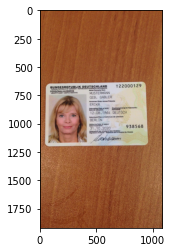

(1920, 1080, 3)

In [58]:
p = '/home/ubuntu/storage/dataset/14_deu_id_new/convert_image/TA/TA14_29.jpg'
# p = '/home/ubuntu/storage/dataset/14_deu_id_new/convert_image/CA/CA14_13.jpg'
image = cv2.imread(p)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image.shape

In [59]:



# 固定尺寸
def resizeImg(image, height=900):
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img


# 邊緣檢測
def getCanny(image):
    # 高斯模糊
    binary = cv2.GaussianBlur(image, (3, 3), 2, 2)
    # print('GaussianBlur')
    # plt.imshow(binary_img)
    # plt.show()
    # print()
    # 邊緣檢測
    binary = cv2.Canny(binary, 60, 240, apertureSize=3)
    # print('Canny')
    # plt.imshow(binary_img)
    # plt.show()
    # print()
    # 膨脹操作，盡量使邊緣閉合
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    # print('dilate')
    # plt.imshow(binary_img)
    # plt.show()
    # print()
    return binary


# 求出面積最大的輪廓
def findMaxContour(image):
    # 尋找邊緣
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 計算面積
    max_area = 0.0
    max_contour = []
    for contour in contours:
        currentArea = cv2.contourArea(contour)
        if currentArea > max_area:
            max_area = currentArea
            max_contour = contour
    return max_contour, max_area


# 多邊形擬合凸包的四個頂點
def getBoxPoint(contour):
    # 多邊形擬合凸包
    hull = cv2.convexHull(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    approx = approx.reshape((len(approx), 2))
    return approx


# 適配原四邊形點集
def adaPoint(box, pro):
    box_pro = box
    if pro != 1.0:
        box_pro = box/pro
    box_pro = np.trunc(box_pro)
    return box_pro


# 四邊形頂點排序，[top-left, top-right, bottom-right, bottom-left]
def orderPoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


# 計算長寬
def pointDistance(a, b):
    return int(np.sqrt(np.sum(np.square(a - b))))


# 透視變換
def warpImage(image, box):
    w, h = pointDistance(box[0], box[1]), \
           pointDistance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(box, dst_rect)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

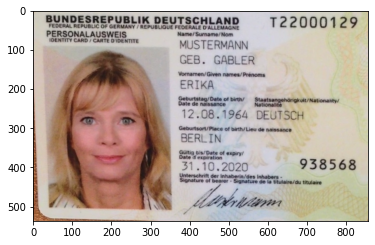

-1

In [60]:
path = p
height = 1920
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
ratio = height / image.shape[0]
img = resizeImg(image, height)
binary_img = getCanny(img)
max_contour, max_area = findMaxContour(binary_img)
boxes = getBoxPoint(max_contour)
boxes = adaPoint(boxes, ratio)
boxes = orderPoints(boxes)
# 透視變換
warped = warpImage(image, boxes)
plt.imshow(warped)
plt.show()
cv2.waitKey(0)

In [44]:
cv2.imwrite("test.png", warped)

True

In [48]:
import pytesseract
from pytesseract import Output

t = '/home/ubuntu/work/t2/test.png'
img = cv2.imread(t)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())


dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


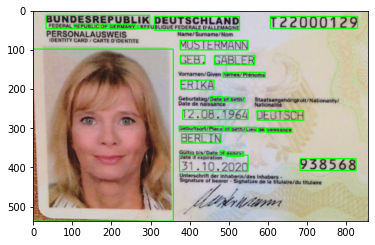

True

In [55]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
cv2.imwrite("test_OCR_box.png", img)


In [50]:
custom_config = r'--oem 3 --psm 6 outputbase digits'
print(pytesseract.image_to_string(img, config=custom_config))

T22000129
PERSONALAUSWEIS Name Surname’ Nom
CR ae aN eam
‘ GEB] GABLER
Vornamen/ Given Ges Bsn
ef ca
j ) Sear gemma nntony,
a \
~ > |)
| Gavsnson7eceorsrncad es samen
i hel | BERLIN
; sueaeacpaies
; 938568
— L Signature cf Comte Se ee inst steno
bP,
; x : Z
. \Se LL wr biltb7007
:


In [51]:
custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
print(pytesseract.image_to_string(img, config=custom_config))

T22000129
PERSONALAUSWEIS Name Surname’ Nom
CR ae aN eam
‘ GEB] GABLER
Vornamen/ Given Ges Bsn
ef ca
j ) Sear gemma nntony,
a \
~ > |)
| Gavsnson7eceorsrncad es samen
i hel | BERLIN
; sueaeacpaies
; 938568
— L Signature cf Comte Se ee inst steno
bP,
; x : Z
. \Se LL wr biltb7007
:


In [53]:
custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
print(pytesseract.image_to_string(img, config=custom_config))

T22000129
PERSONALAUSWEIS Name Surname’ Nom
CR ae aN eam
‘ GEB] GABLER
Vornamen/ Given Ges Bsn
ef ca
j ) Sear gemma nntony,
a \
~ > |)
| Gavsnson7eceorsrncad es samen
i hel | BERLIN
; sueaeacpaies
; 938568
— L Signature cf Comte Se ee inst steno
bP,
; x : Z
. \Se LL wr biltb7007
:
